<a id=top></a>

# Megafon

1. [Info](#info)
1. [Load Data and Modules](#load)
1. [Exploratory Data Analysis](#explore)
1. [Derived (engineered) features](#derived)
1. [Modelling](#model)
1. [Creating pipeline](#pipeline)
1. [Submit](#commit)

<a id=info></a>
### Info

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:
data_train.csv: id, vas_id, buy_time, target
features.csv.zip: id, <feature_list> 

И тестовый набор:
data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга

Формат представления результата
Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
Код модели можно представить в виде jupyter-ноутбука. 
Презентация в формате .pdf, в которой необходимо отразить:
Информация о модели, ее параметрах, особенностях и основных результатах.
Обоснование выбора модели и ее сравнение с альтернативами.
Принцип составления индивидуальных предложений для выбранных абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

In [1]:
TARGET='target'
RANDOM_STATE=42

## Load Data and Modules
<a id=load></a>

In [2]:
import os
import pickle
import time
import random
from datetime import datetime, timedelta

In [3]:
import pandas as pd
import numpy as np

In [4]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [9]:
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [10]:
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [11]:
def time_format(sec):
    return str(timedelta(seconds=sec))

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn-white')
sns.set(rc={'figure.figsize': (6,9)})

pd.options.display.float_format = '{:.3f}'.format

In [14]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Functions

In [15]:
def optimizing_dd(df, silent=False):    
    assert isinstance(df, dd.DataFrame), 'This is not a dask dataframe'
    start_t = time.time()
    
    if not silent:
        start_memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('Start of dataframe memory optimization'.center(100,'*'))
        print(f'Memory usage by dataframe: {start_memory_usage.result():.02f} MB')
    
    df_dtype = pd.DataFrame(df.dtypes, columns=['dtype'], index = df.columns)
    
    df_min = client.compute(df.select_dtypes(['int', 'float']).min())
    df_max = client.compute(df.select_dtypes(['int', 'float']).max())
    df_is_int = client.compute(~(df.select_dtypes(['int', 'float']).fillna(0).astype(int).sum() - df.select_dtypes(['int', 'float']).fillna(0).sum()).astype('bool_'))
    
    df_dtype['min'] = df_min.result()
    df_dtype['max'] = df_max.result()
    df_dtype['is_int'] = df_is_int.result()
    
    df_dtype.loc[(df_dtype['is_int'] == True),'dtype'] = 'int64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int32').min) & (df_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int16').min) & (df_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int8').min) & (df_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint32').min) & (df_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint16').min) & (df_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint8').min) & (df_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] == 0) & (df_dtype['max'] == 1),'dtype'] = 'bool_'
    
    df_dtype.loc[(df_dtype['is_int'] == False), 'dtype'] = 'float64'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float32').min) & (df_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float16').min) & (df_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
    
    for col in df.select_dtypes('object').columns:
        num_unique_values = client.compute(df[col].nunique())
        num_total_values = client.compute(df['id'].shape)
        if num_unique_values.result() / num_total_values[0].result() < 0.5:
            df_dtype.loc[col, 'dtype'] = 'category'
    
    dtypes = df_dtype['dtype'].to_dict()
    
    df = df.astype(dtypes)
    
    if not silent:
        memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('MEMORY USAGE AFTER COMPLETION:'.center(40,'_'))
        print(f'Memory usage of properties dataframe is : {memory_usage.result():.02f} MB')
        print(f'This is {100*memory_usage.result()/start_memory_usage.result():.02f} % of the initial size')
        print(f'End of dataframe memory optimization, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    return df

### Load data

In [16]:
train = pd.read_csv('data_train.csv', index_col=[1]) \
            .drop('Unnamed: 0', axis=1)

In [17]:
train.head()

,vas_id,buy_time,target
id,,,
540968,8.000,1537131600,0.000
1454121,4.000,1531688400,0.000
2458816,1.000,1534107600,0.000
3535012,5.000,1535922000,0.000
1693214,1.000,1535922000,0.000


In [18]:
if os.path.exists('features.pkl'):
    features = pd.read_pickle('features.pkl')

In [17]:
if not os.path.exists('features.pkl'):
    cluster = LocalCluster(n_workers=2)
    client = Client(cluster)
    
    features = dd.read_csv('features.csv', sep='\t') \
                .drop('Unnamed: 0', axis=1)
    
    features = optimizing_dd(features)
    features = features.set_index('id')

    features = features.compute()

    features.to_pickle('features.pkl')    

*******************************Start of dataframe memory optimization*******************************
Memory usage by dataframe: 8779.15 MB
_____MEMORY USAGE AFTER COMPLETION:_____
Memory usage of properties dataframe is : 2663.90 MB
This is 30.34 % of the initial size
*******************End of dataframe memory optimization, run time: 0:04:54.720704*******************


In [19]:
features.head()

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
0,1539550800,-87.480,-258.499,-93.791,-192.487,-99.208,-213.592,-16.086,-65.076,-6.784,...,-977.374,-613.771,-25.996,-37.625,-306.748,-25.833,-0.694,-12.176,-0.456,0
1,1546808400,-95.300,-47.949,-55.071,-42.147,-60.488,-63.252,-16.086,-65.076,-6.784,...,-952.374,-611.771,-25.996,-17.625,-250.748,-17.833,-0.694,-12.176,-0.456,0
2,1545598800,-96.800,229.531,-110.741,305.723,-116.158,284.618,-16.086,-65.076,-6.784,...,2300.626,1492.229,-21.996,-35.625,368.252,11.167,7.305,-12.176,-0.456,0
3,1544994000,-25.610,-275.969,-27.691,-287.057,-33.108,-308.162,-16.086,-65.076,-6.784,...,971.626,-613.771,-25.996,-37.625,-229.748,-19.833,-0.694,-12.176,-0.456,0
4,1538341200,-96.800,-323.429,-110.741,-376.037,-116.158,-397.142,-16.086,19.674,-6.784,...,4806.626,4140.229,-25.996,-37.625,-35.748,-20.833,-0.694,-7.176,-0.456,0


[Go to the top of the page](#top)

## Exploratory Data Analysis
<a id=explore></a>

#### Target Variable Distribution

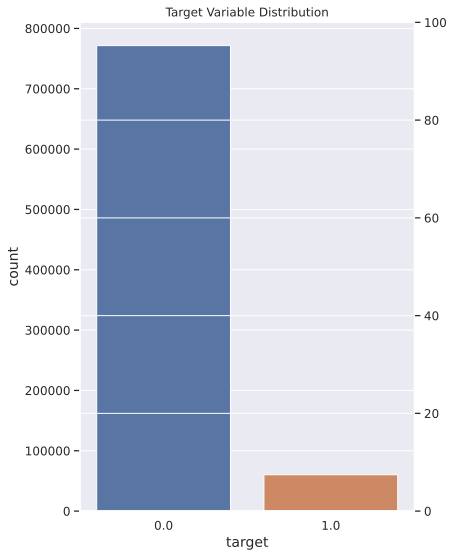

In [20]:
plt.title('Target Variable Distribution')
sns.countplot(x=TARGET, data=train).twinx().set_ylim(0,100);

### Examine Missing Values

In [21]:
print(f'Missing values in train data: {train.isnull().sum().sum() / train.count().sum() * 100:.02f} % of total Values')

Missing values in train data: 0.00 % of total Values


In [22]:
print(f'Missing values in features data: {features.isnull().sum().sum() / features.count().sum() * 100:.02f} % of total Values')

Missing values in features data: 0.00 % of total Values


[Go to the top of the page](#top)

## Derived (engineered) features
<a id=derived></a>

### Splitting the train sample

In [19]:
X = train.drop(columns=TARGET)
y = train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=RANDOM_STATE)

In [20]:
del(X)
del(y)

### Features type determination

In [21]:
features_train = features[features.index.isin(X_train.index.unique())]

In [22]:
features_train = features_train.sort_values('buy_time')

In [23]:
features_train = features_train.groupby('id').last()

In [24]:
df = X_train.merge(features_train, left_index=True, right_index=True, how='left', suffixes=('_train', '_features'))

In [25]:
df_nunique = df.apply(lambda x: x.nunique(dropna=False))

In [26]:
df_nunique.shape

(256,)

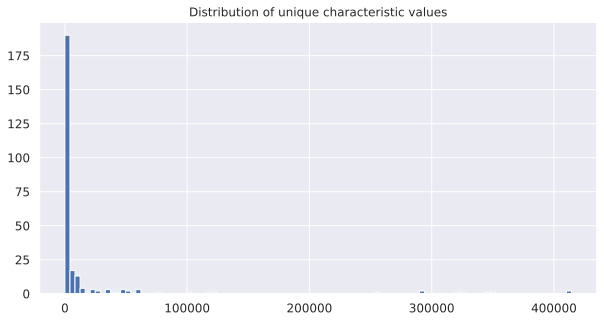

In [27]:
plt.title('Distribution of unique characteristic values');
df_nunique.hist(bins=100, figsize=(10, 5));

In [28]:
f_all = set(df_nunique.index.tolist())
len(f_all)

256

#### Timestamp features

In [29]:
f_date = set(col for col in df.columns if 'time' in col)

len(f_date)

2

In [30]:
f_other = f_all - f_date

len(f_other)

254

#### Constant features

In [31]:
f_const = set(df_nunique[df_nunique == 1].index.tolist())

len(f_const)

5

In [32]:
f_other = f_other - f_const

len(f_other)

249

#### Numeric features

In [33]:
f_numeric = (df.fillna(0).astype(int).sum() - df.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())

len(f_numeric)

244

In [34]:
f_other = f_other - f_numeric
len(f_other)

5

#### Binary features

In [35]:
f_binary = set(df.loc[:, f_other].columns[(
                      (df.loc[:, f_other].max() == 1) & \
                      (df.loc[:, f_other].min() == 0) & \
                      (df.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

In [36]:
f_other = f_other - f_binary
len(f_other)

5

#### Categorical features

In [37]:
f_categorical = set(df_nunique.loc[f_other][df_nunique.loc[f_other] <= 10].index.tolist())
len(f_categorical)

1

In [38]:
f_other = f_other - f_categorical
len(f_other)

4

#### Other features

In [39]:
f_numeric = f_numeric | f_other

In [40]:
f_other = f_other - f_numeric
len(f_other)

0

In [41]:
assert(df_nunique.shape[0] == len(f_date) + len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [42]:
print(f'f_all: {df.shape[1]}\n')
print(f'f_date: {len(f_date)}')
print(f'f_const: {len(f_const)}')
print(f'f_binary: {len(f_binary)}')
print(f'f_categorical: {len(f_categorical)}')
print(f'f_numeric: {len(f_numeric)}')

f_ok = list(X_train.columns)

f_date = list(f_date)
f_binary = list(f_binary)
f_categorical = list(f_categorical)
f_numeric = list(f_numeric)

f_all: 256

f_date: 2
f_const: 5
f_binary: 0
f_categorical: 1
f_numeric: 248


In [43]:
del(features_train)
del(df)

### Pipeline adding features

In [44]:
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features, silent=True):
        self.features = features
        self.silent = silent
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not self.silent:
            start_t = time.time()
            print('Start adding features'.center(100,'*'))
        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe'
              
        X_features = self.features.loc[self.features.index.isin(X.index.unique())]

        X_features = X_features.sort_values('buy_time') \
                                .groupby('id').last()

        X_merge = X.reset_index() \
                    .merge(X_features.reset_index(),  on=X.index.name, how='left', suffixes=('_train', '_features')) \
                    .set_index(X.index.name)
          
        assert X_merge.shape[0] == X.shape[0], f'Shapes of dataframe don\'t match: {X_merge.shape[0]} and {X.shape[0]}'
        assert (X_merge.index == X.index).all(), 'Index Sort Error'
        if not self.silent:
            print(f'End adding features, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
            print()
            
        return X_merge

In [45]:
class GetDate(BaseEstimator, TransformerMixin):
    def __init__(self, silent=True):
        self.silent = silent
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not self.silent:
            start_t = time.time()
            print('Start geting date from timestamp'.center(100,'*'))
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)

        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe or series'
        
        df = pd.DataFrame()
        
        for col in X.columns:
            df[f'{col}_day'] = pd.to_datetime(X[col], unit='s').dt.day
            df[f'{col}_month'] = pd.to_datetime(X[col], unit='s').dt.month
            df[f'{col}_week'] = pd.to_datetime(X[col], unit='s').dt.week
            
        if not self.silent:
            print(f'End geting date from timestamp, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
            print()
        return df

### Pipeline memory use optimizing

In [46]:
class MemUseOptimizing(BaseEstimator, TransformerMixin):
    def __init__(self, silent=True):
        self.silent = silent

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        start_t = time.time()
        
        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe'
    
        if not self.silent:
            print('Start of dataframe memory use optimizing'.center(100,'*'))
            start_memory_usage = X.memory_usage(deep=True).sum() / 1024**2 
            
        
            X_dtype = pd.DataFrame(X.dtypes, columns=['dtype'], index = X.columns)                
            
            X_dtype['min'] = X.select_dtypes(['int', 'float']).min()
            X_dtype['max'] = X.select_dtypes(['int', 'float']).max()
            X_dtype['is_int'] = ~(X.select_dtypes(['int', 'float']).astype(int).sum() - X.select_dtypes(['int', 'float']).sum()).astype('bool_')
            
            X_dtype.loc[(X_dtype['is_int'] == True),'dtype'] = 'int64'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int32').min) & (X_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int16').min) & (X_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int8').min) & (X_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
            
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint32').min) & (X_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint16').min) & (X_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint8').min) & (X_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
            
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] == 0) & (X_dtype['max'] == 1),'dtype'] = 'bool_'
            
            X_dtype.loc[(X_dtype['is_int'] == False), 'dtype'] = 'float64'
            X_dtype.loc[(X_dtype['is_int'] == False) & (X_dtype['min'] >= np.finfo('float32').min) & (X_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
            X_dtype.loc[(X_dtype['is_int'] == False) & (X_dtype['min'] >= np.finfo('float16').min) & (X_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
            
            for col in X.select_dtypes('object').columns:
                num_unique_values = len(X[col].unique())
                num_total_values = len(X[col])
                if num_unique_values / num_total_values < 0.5:
                    X_dtype.loc[col, 'dtype'] = 'category'
                    
            dtype = X_dtype['dtype'].to_dict()
                   
            X = X.astype(dtype)
            
        if not self.silent:
            memory_usage = X.memory_usage(deep=True).sum() / 1024**2
            print('Memory use optimizing'.center(100,'*'))
            print(f'Memory usage of properties dataframe before optimizing: {start_memory_usage:.02f} MB')
            print(f'Memory usage of properties dataframe after optimizing: {memory_usage:.02f} MB')      
            print(f'This is {100*memory_usage/start_memory_usage:.02f} % of the initial size')
            print(f'End of dataframe memory use optimizing, run time: {time_format(time.time()-start_t)}'.center(64,'*'))
            print()
                
        return X

### Pipeline processing features

In [47]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
      
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame does not contain the following columns: {cols_error}')

In [48]:
feature_union_pipeline = FeatureUnion(transformer_list=[
                        ('date_features', make_pipeline(
                            ColumnSelector(f_date),
                            GetDate(),
                            StandardScaler()
                        )),
                        ('numeric_features', make_pipeline(
                            ColumnSelector(f_numeric),
                            SimpleImputer(strategy='constant', fill_value=0),
                            StandardScaler(),
                        )),
                        ('categorical_features', make_pipeline(
                            ColumnSelector(f_categorical),
                            SimpleImputer(strategy='most_frequent'),
                            OneHotEncoder(handle_unknown='ignore', sparse=False)
                        )),
                        ('boolean_features', make_pipeline(
                            ColumnSelector(f_binary),
                        ))
])

In [49]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    AddFeatures(features),
    MemUseOptimizing(),
    feature_union_pipeline
)

In [50]:
n_features = f_prep_pipeline.fit_transform(X_test).shape
n_features

(249496, 262)

[Go to the top of the page](#top)

## Modelling
<a id=model></a>

In [51]:
def get_classification_report(models_list, X_train, y_train, 
                                        X_test, y_test, 
                                        classes,
                                        title='',
                                        threshold=0.5):
    
    for model_name, model in models_list.items():
        print()
        y_train_pred = model.predict_proba(X_train)[:,1]
        y_test_pred = model.predict_proba(X_test)[:,1]
        
        y_train_pred = y_train_pred > threshold
        y_test_pred = y_test_pred > threshold
        
        print(f'{model_name}. {title}'.center(53, '*'))
        print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
        print('TEST\n\n' + classification_report(y_test, y_test_pred))
        plt.figure(figsize=(7, 4))
        plot_confusion_matrix(y_test, y_test_pred, classes=classes, title=f'Confusion matrix.\n {model_name}. {title}')
        plt.show()
        print('_'*53)
        print('\n')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center', fontsize=16,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #filename = title.replace("\n","") + '.png'
    #plt.savefig(filename, format='png', dpi=300)
    
def plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='', threshold=0.5):

    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    
    f.set_figheight(10)
    f.set_figwidth(20)
    
    ax1 = plt.subplot(121)
    ax1.set_title(f'ROC. {title}')
    ax1.set_xlabel('TPR')
    ax1.set_ylabel('FPR')
    ax1.set_aspect('equal')
    ax1.plot([0, 1], [0, 1], 'k--')
    
    ax2 = plt.subplot(122)
    ax2.set_title(f'PR. {title}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_aspect('equal')
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax2.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02), fontsize=14)
        
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    for model_name, model in models_list.items():
        y_pred_proba = model.predict_proba(X_test)[:,1]
        y_pred = y_pred_proba > threshold
        
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
        
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC={auc(fpr, tpr):.2f})')       
        ax2.plot(recall, precision, label=f'{model_name} (f1={f1_score(y_test, y_pred):.2f})')

    ax1.legend(loc="lower right")
    ax2.legend(loc="lower left")
    
    #filename = title.replace('\n', '') + '_ROC_PF.png'
    #plt.savefig(filename, format='png', dpi=300)
    
    plt.show()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(1, 1))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    
    #plt.savefig('show_proba_calibration_plots.png', format='png', dpi=300)
    plt.show()

### Baseline models

In [56]:
models_list = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'),
}

#### Fit models

In [57]:
for model_name, model in models_list.items():
    start_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    print()

***********************************Start fit Logistic Regression************************************
***********************End fit Logistic Regression, run time: 0:00:01.041835************************

*********************************Start fit Random Forest Classifier*********************************
*********************End fit Random Forest Classifier, run time: 0:00:07.193511*********************

*****************************************Start fit XGBoost******************************************
*****************************End fit XGBoost, run time: 0:00:14.759986******************************

*****************************************Start fit LightGBM*****************************************
*****************************End fit LightGBM, run time: 0:00:02.429151*****************************

*****************************************Start fit CatBoost*****************************************
*****************************End fit CatBoost, run time: 0:00:39.730206****************


************Logistic Regression. Baseline************
TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    540047
         1.0       0.00      0.00      0.00     42110

    accuracy                           0.93    582157
   macro avg       0.46      0.50      0.48    582157
weighted avg       0.86      0.93      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    231420
         1.0       0.00      0.00      0.00     18076

    accuracy                           0.93    249496
   macro avg       0.46      0.50      0.48    249496
weighted avg       0.86      0.93      0.89    249496



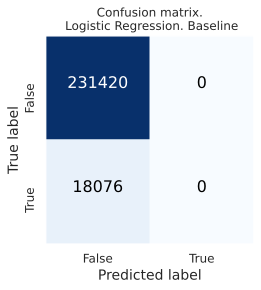

_____________________________________________________



**********Random Forest Classifier. Baseline*********
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



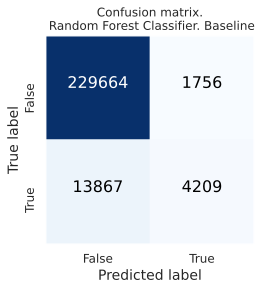

_____________________________________________________



******************XGBoost. Baseline******************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



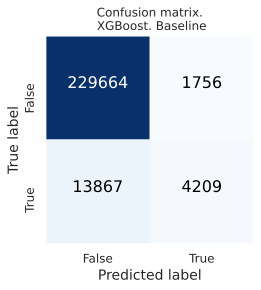

_____________________________________________________



******************LightGBM. Baseline*****************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



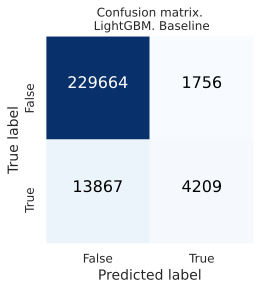

_____________________________________________________



******************CatBoost. Baseline*****************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



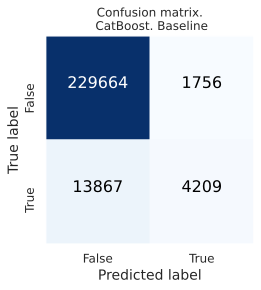

_____________________________________________________




In [58]:
get_classification_report(
                        models_list, \
                        X_train, y_train, X_test, y_test, \
                        classes=['False', 'True'], \
                        title='Baseline'
                             )

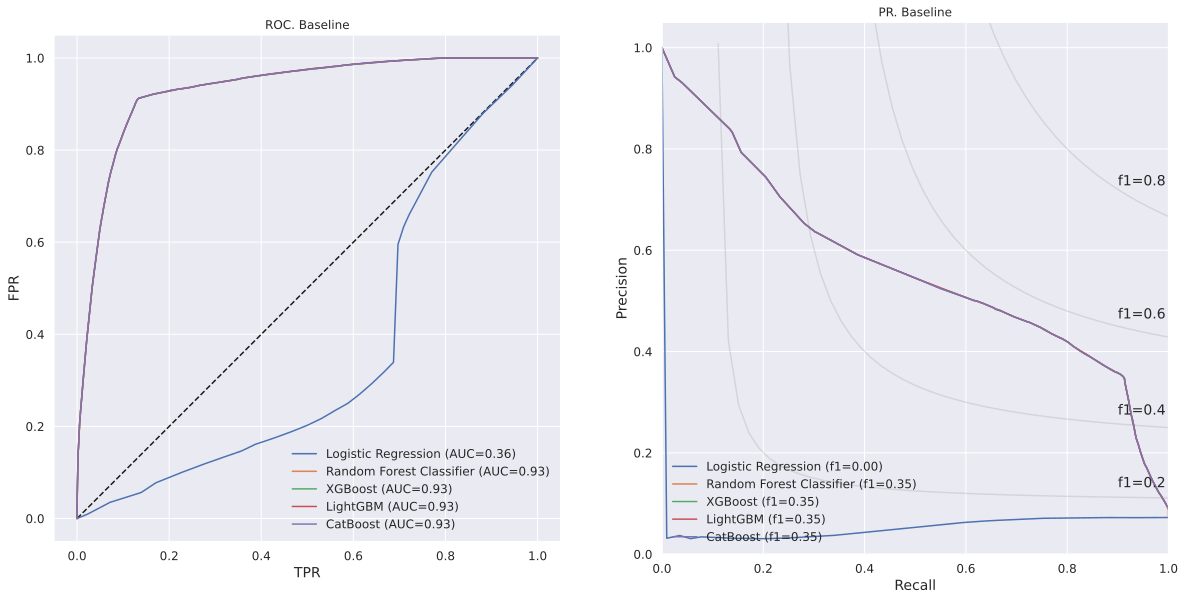

In [59]:
plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='Baseline')

### Feature Selection

In [60]:
X_train_prep = f_prep_pipeline.fit_transform(X_train)
X_train_prep.shape

(582157, 262)

In [61]:
X_test_prep = f_prep_pipeline.transform(X_test)
X_test_prep.shape

(249496, 262)

In [62]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
model_select = SelectFromModel(model_lgbm, threshold=1e-5)
X_train_prep = model_select.fit_transform(X_train_prep, y_train)
X_test_prep = model_select.transform(X_test_prep)

In [63]:
X_train_prep.shape

(582157, 206)

In [64]:
X_test_prep.shape

(249496, 206)

### Balancing classes

In [65]:
def get_f1(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    return train_f1, test_f1    

In [67]:
n_sampling_strategy = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]

model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

smote_results = pd.DataFrame(columns=['train', 'test'], index=n_sampling_strategy)

smote_results.loc[0] = get_f1(model_lgbm, X_train_prep, y_train, X_test_prep, y_test)

for sampling_strategy in n_sampling_strategy[1:]:
    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = sm.fit_sample(X_train_prep, y_train)
    smote_results.loc[sampling_strategy] = get_f1(model_lgbm, X_train_balanced, y_train_balanced, X_test_prep, y_test)

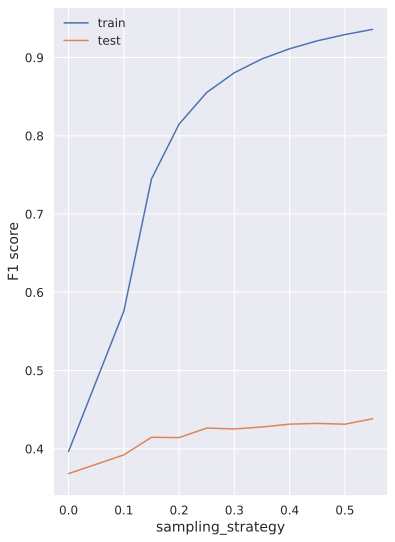

In [68]:
ax = smote_results.plot()
ax.set_xlabel('sampling_strategy')
ax.set_ylabel('F1 score');

In [62]:
rf_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('Random Forest', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)),
])

xgb_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('XGBoost', XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)),
])

lgbm_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
])

cat_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
])

In [70]:
pipe_list = {
    'Random Forest Classifier': rf_pipe,
    'LightGBM': lgbm_pipe,
}

#### Fit models

In [71]:
for model_name, model in pipe_list.items():
    start_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    print()

*********************************Start fit Random Forest Classifier*********************************
*********************End fit Random Forest Classifier, run time: 0:05:20.496965*********************

*****************************************Start fit LightGBM*****************************************
*****************************End fit LightGBM, run time: 0:04:53.750397*****************************




*****Random Forest Classifier. Balancing classes*****
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    540047
         1.0       1.00      1.00      1.00     42110

    accuracy                           1.00    582157
   macro avg       1.00      1.00      1.00    582157
weighted avg       1.00      1.00      1.00    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.61      0.24      0.35     18076

    accuracy                           0.93    249496
   macro avg       0.77      0.62      0.66    249496
weighted avg       0.92      0.93      0.92    249496



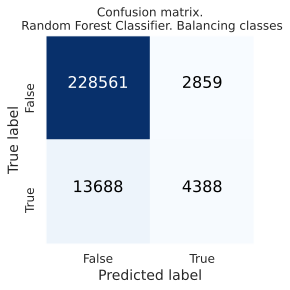

_____________________________________________________



*************LightGBM. Balancing classes*************
TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    540047
         1.0       0.67      0.32      0.43     42110

    accuracy                           0.94    582157
   macro avg       0.81      0.65      0.70    582157
weighted avg       0.93      0.94      0.93    582157

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    231420
         1.0       0.63      0.30      0.41     18076

    accuracy                           0.94    249496
   macro avg       0.79      0.64      0.69    249496
weighted avg       0.92      0.94      0.93    249496



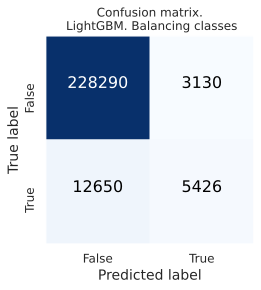

_____________________________________________________




In [72]:
get_classification_report(
                        pipe_list, \
                        X_train, y_train, X_test, y_test, \
                        classes=['False', 'True'], \
                        title='Balancing classes'
                             )

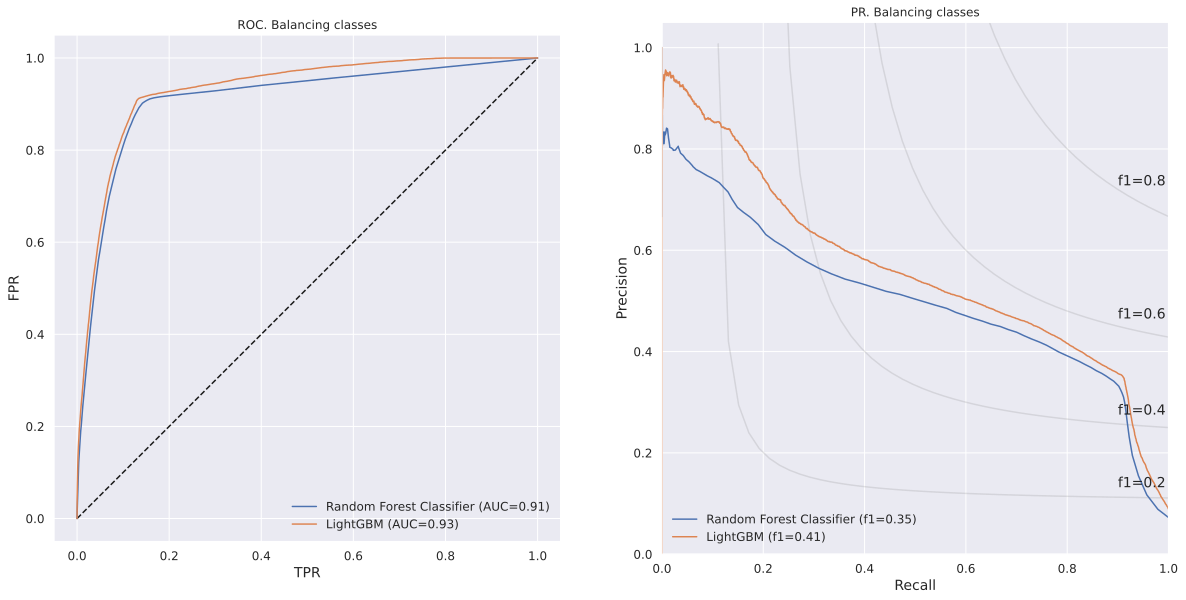

In [73]:
plot_roc_pr(pipe_list, X_train, y_train, X_test, y_test, title='Balancing classes')

### Randomized Search

In [74]:
cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

In [75]:
param_grid = {
                'SelectFromModel__threshold': [-np.inf, 1e-05],
                'LightGBM__class_weight': [None, 'balanced'],
                'LightGBM__learning_rate': np.arange(0.01, 1.0, 0.05),
                'LightGBM__max_depth': np.arange(3, 10, 1),
                'LightGBM__min_child_weight': np.arange(0.001, 1, 0.005),
                'LightGBM__n_estimators': np.arange(100, 500, 50),
                'LightGBM__num_leaves': np.arange(10, 50, 5),
                'LightGBM__reg_alpha': np.arange(0.0, 1.5, 0.05),
                'LightGBM__reg_lambda': np.arange(0.0, 1.0, 0.05),
                'LightGBM__subsample': np.arange(0.2, 1.0, 0.1),
}

In [76]:
cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
grid = RandomizedSearchCV(lgbm_pipe, param_grid, scoring='f1', cv=cv)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ColumnSelector',
                                              ColumnSelector(columns=['vas_id',
                                                                      'buy_time'])),
                                             ('AddFeatures',
                                              AddFeatures(features=           buy_time       0        1        2        3        4        5  \
id                                                                         
0        1539550800 -87.480 -258.499  -93.791 -192.487  -99.208 -213.592   
1        1546808400 -95.300  -47.949  -55.071  -42.147  -60.488  -63.252...
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45]),
                                        'LightGBM__reg_lambda': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 

In [77]:
print(f'Best f1 score: {grid.best_score_:.2f}')

print()
print(f'Best parameters set found on development set:')
print()
print(grid.best_params_)

print()
print('Grid scores on development set:')
print()

for i, params in enumerate(grid.cv_results_['params']):
    print(f'{grid.cv_results_["mean_test_score"][i]:0.3f} (+/-{grid.cv_results_["std_test_score"][i] * 2:0.03f})')

print()

Best f1 score: 0.51

Best parameters set found on development set:

{'SelectFromModel__threshold': 1e-05, 'LightGBM__subsample': 0.5000000000000001, 'LightGBM__reg_lambda': 0.6000000000000001, 'LightGBM__reg_alpha': 0.75, 'LightGBM__num_leaves': 25, 'LightGBM__n_estimators': 350, 'LightGBM__min_child_weight': 0.551, 'LightGBM__max_depth': 6, 'LightGBM__learning_rate': 0.060000000000000005, 'LightGBM__class_weight': 'balanced'}

Grid scores on development set:

0.413 (+/-0.009)
0.477 (+/-0.012)
0.424 (+/-0.016)
0.505 (+/-0.001)
0.511 (+/-0.004)
0.508 (+/-0.001)
0.353 (+/-0.007)
0.414 (+/-0.002)
0.404 (+/-0.021)
0.429 (+/-0.003)



### Final model

In [52]:
model_parameters = {
            'SelectFromModel__threshold': 1e-05, 
            'LightGBM__subsample': 0.50, 
            'LightGBM__reg_lambda': 0.60, 
            'LightGBM__reg_alpha': 0.75, 
            'LightGBM__num_leaves': 25, 
            'LightGBM__n_estimators': 350, 
            'LightGBM__min_child_weight': 0.551, 
            'LightGBM__max_depth': 6, 
            'LightGBM__learning_rate': 0.06, 
            'LightGBM__class_weight': 'balanced'
}

In [53]:
final_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE))),
                    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
])

In [54]:
final_pipe.set_params(**model_parameters);

In [55]:
final_pipe.fit(X_train, y_train);


*************LightGBM. Final model. Final************
TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    540047
         1.0       0.36      0.90      0.52     42110

    accuracy                           0.88    582157
   macro avg       0.68      0.89      0.72    582157
weighted avg       0.95      0.88      0.90    582157

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    231420
         1.0       0.36      0.90      0.51     18076

    accuracy                           0.88    249496
   macro avg       0.67      0.89      0.72    249496
weighted avg       0.95      0.88      0.90    249496



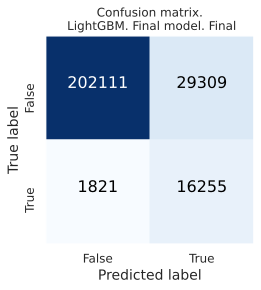

_____________________________________________________




In [56]:
get_classification_report(
                        {'LightGBM': final_pipe}, \
                        X_train, y_train, X_test, y_test, \
                        classes=['False', 'True'], \
                        title='Final model'
                             )

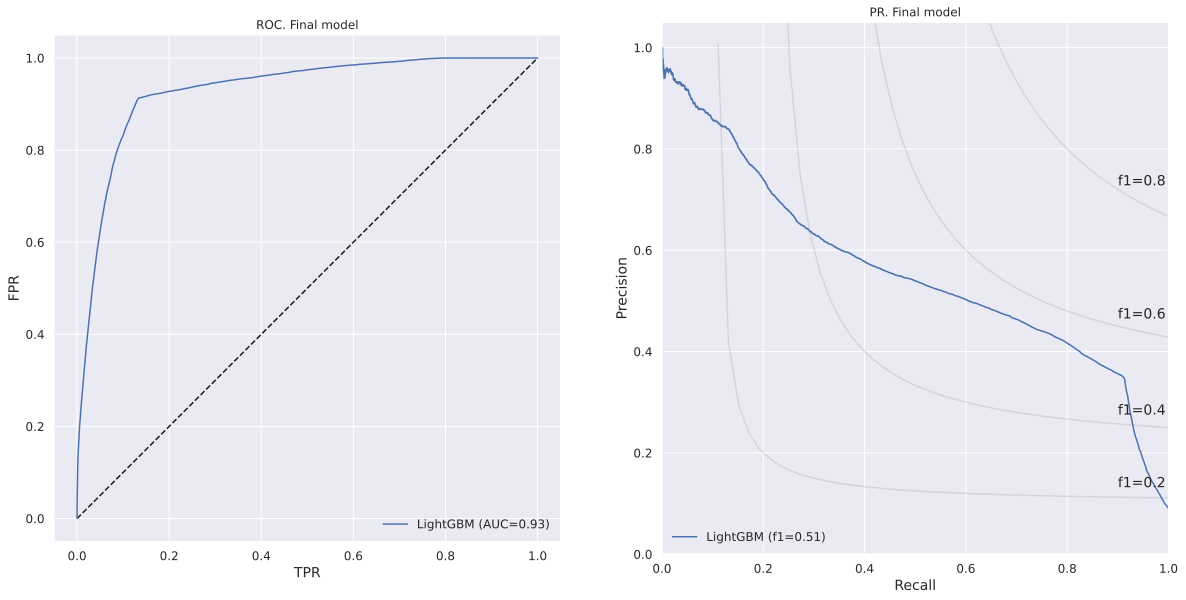

In [57]:
plot_roc_pr({'LightGBM': final_pipe}, X_train, y_train, X_test, y_test, title='Final model')

### Probability calibration

In [98]:
y_test_pred_probs = final_pipe.predict_proba(X_test)

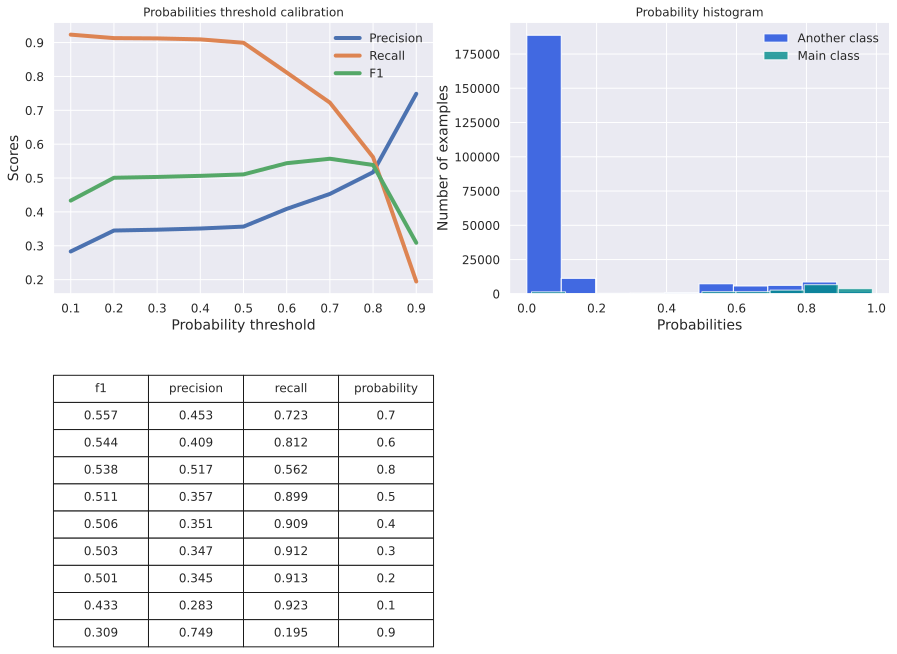

In [86]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)


****LightGBM. Final model. Probability threshold.****
TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96    540047
         1.0       0.47      0.74      0.57     42110

    accuracy                           0.92    582157
   macro avg       0.72      0.84      0.76    582157
weighted avg       0.94      0.92      0.93    582157

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95    231420
         1.0       0.45      0.72      0.56     18076

    accuracy                           0.92    249496
   macro avg       0.71      0.83      0.76    249496
weighted avg       0.94      0.92      0.93    249496



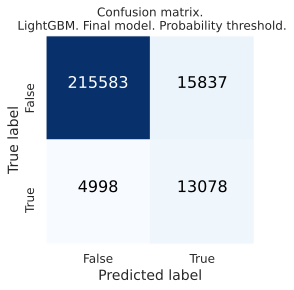

_____________________________________________________




In [59]:
get_classification_report(
                        {'LightGBM': final_pipe}, \
                        X_train, y_train, X_test, y_test, \
                        classes=['False', 'True'], \
                        title='Final model. Probability threshold.',
                        threshold=0.7
                             )

### Comparison of models

In [73]:
model_list_final = {
                'LightGBM. Baseline': LGBMClassifier(random_state=RANDOM_STATE),
                'LightGBM. Final model': final_pipe
}

#### Fit models

In [74]:
for model_name, model in model_list_final.items():
    start_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    print()

************************************Start fit LightGBM. Baseline************************************
************************End fit LightGBM. Baseline, run time: 0:00:00.961056************************

**********************************Start fit LightGBM. Final model***********************************
**********************End fit LightGBM. Final model, run time: 0:03:43.601051***********************



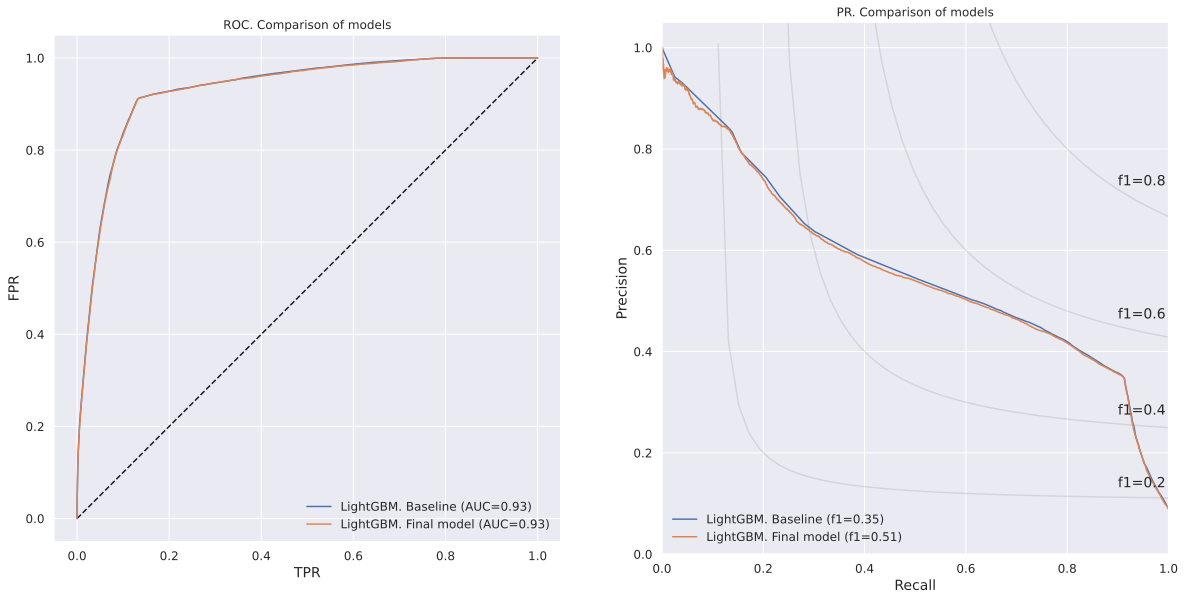

In [79]:
plot_roc_pr(model_list_final, X_train, y_train, X_test, y_test, title='Comparison of models')

[Go to the top of the page](#top)

## Submit
<a id=commit></a>

In [80]:
with open('model.pkl', 'wb') as f:
    pickle.dump(final_pipe, f)

[Go to the top of the page](#top)